# Definitions

* $ l \in \mathbf{N}^+ $: Number of levels.
* $ L = \{ x \  | \  x \in \mathbf{N}^0 \land x \lt l \} $: Person levels. Smaller value is higher position. $0$ is the top.
* $ p_x \  (x \in L) $. A person on $x$-level.
* $ a_{x \rightarrow P} \in \mathbf{N}^0 \  (P \subsetneq L, x \in L \setminus P)  $: An action that $x$-level person tells info to each $P$-level person.
  * Assuming $ a_{x \rightarrow P} $ does not affect to $p_x$. Self understanding is wrong.
* $ A_t = [a_{x_0 \rightarrow P_0}, a_{x_1 \rightarrow P_1}, \ldots] \  (t = |A_t|) $: All actions to get to the state.
  * $ A_0 = [] $.
  * $ {| A_t |}_x $ means, Number of $x$-level performs an action.
* $ u_x^{A_t} \  (x \in L, 0 \leq u_x^{A_t} \leq 1) $: Understanding of $x$-level person after ${A_t}$ from initial state($u_x^{A_0}$).
  * $ u_y^{A_{t + 1}} \ (y \in P, A_{t + 1} = A_t + [a_{x_t \rightarrow P_t}]) = \max(u_y^{A_t}, \min(u_x^{A_t}, u_y^{A_t} + \frac{u_x^{A_t}}{\sqrt{\frac{\sum_{y \in P}|p_y|}{|p_x|}}})) $
* $ L_{term} \  (L_{term} \neq \emptyset \land L_{term} \subseteq L) $: When $ u_x^{A_t} = 1 \  (x \in L_{term}) $, it terminates.

```mermaid
graph TD
    1[p_1, has u_1]
    subgraph team1[ ]
      11[p_2, has u_2] -- t_2->{3} -->
        l11[p_3, has u_3] & l12[p_3, has u_3]
      12[p_2, has u_2] -- t_2->{3} -->
      121[p_3, has u_3] & 122[p_3, has u_3]
    end
    1 -- t_1->{2} --> 11 & 12
    1 -- t_1->{2,3} --> team1

```

# Simulations

## Top-down message to all members

It means,

* $ | p_0 | = 1 $
* For $ a_{x \rightarrow Y} $, $ Y = \{y \  | \  y \gt x\} $
* $ u_0^{A_0} = 1 $ and $ u_x^{A_0} = 0 \  (x \in L \setminus \{0\}) $
* $ a_{x \rightarrow P} $ cannot be defined.

In [25]:
import copy
import math
from itertools import repeat
from typing import Unpack, TypedDict, Optional

import pygraphviz as pgv

type Action = tuple[int, list[int]]


class State(TypedDict):
  u: list[float]
  t: int
  prev_id: Optional[int]
  prev_action_index: Optional[int]
  n_a: list[int]
  initial: bool
  termination: bool


class Search:
  class Params(TypedDict):
    n_p: list[float]
    a: list[Action]
    u0: list[float]
    L_term: list[int]

  def __init__(self, l: int, **kwargs: Unpack[Params]):
    if l < 1:
      raise ValueError("l must be positive")

    n_p = kwargs["n_p"]
    a = kwargs["a"]
    u0 = kwargs["u0"]
    L_term = kwargs["L_term"]

    if len(n_p) != l:
      raise ValueError("n_p must have length l")
    if len(u0) != l:
      raise ValueError("a must have length u0")
    if len(L_term) > l:
      raise ValueError("L_term must have length less than or equal l")

    self.l = l
    self.n_p = n_p
    self.a = a
    self.u0 = u0
    self.L_term = L_term

    initial_state: State = {"u": u0, "t": 0, "prev_id": None, "prev_action_index": None, "n_a": list(repeat(0, l)),
                            "initial": True,
                            "termination": False}
    self.states = {0: initial_state}

  def search(self) -> None:
    if self.__terminates(self.u0):
      self.states[0]["termination"] = True
      return

    queue = [(0, action_index) for action_index in range(0, len(self.a))]

    while len(queue) > 0:
      (current_state_id, action_index) = queue.pop(0)
      current_state = self.states[current_state_id]
      (action_from, action_to) = self.a[action_index]

      u = current_state["u"]
      P = action_to

      x = action_from
      denominator = math.sqrt(sum(self.n_p[y] for y in P) / self.n_p[x])
      new_u = copy.deepcopy(u)
      new_n_a = copy.deepcopy(current_state["n_a"])
      new_n_a[x] += 1
      for y in P:
        new_u[y] = max(u[y], min(u[x], u[y] + u[x] / denominator))

      termination = self.__terminates(new_u)
      new_state: State = {"u": new_u, "t": current_state["t"] + 1, "prev_id": current_state_id,
                          "prev_action_index": action_index, "n_a": new_n_a, "initial": False,
                          "termination": termination}
      new_state_id = len(self.states)
      self.states[new_state_id] = new_state

      if termination:
        continue

      for action_index in range(0, len(self.a)):
        queue.append((new_state_id, action_index))

  def draw(self) -> pgv.AGraph:
    g = pgv.AGraph(directed=True)

    for (state_id, state) in self.states.items():
      g.add_node(str(state_id), label=f"u=[{",".join("{:.1f}".format(u_x) for u_x in state["u"])}] @{state["n_a"]}",
                 xlabel=f"t={state["t"]}",
                 style="filled" if state["termination"] else "solid",
                 shape="doublecircle" if state["initial"] else "ellipse")
      if state["prev_action_index"] is not None:
        g.add_edge(str(state["prev_id"]), str(state_id), label=f"a[{state["prev_action_index"]}]")

    g.layout("dot")
    return g

  def __terminates(self, u: list[float]) -> bool:
    return all([u[x] >= 1 for x in self.L_term])

### $ l = 1 $
* $ L = \{0\}$
* $ L_{term} = \{0\}$

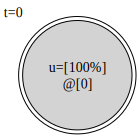

In [26]:
search = Search(1, n_p=[1], a=[], u0=[1], L_term=[0])
search.search()

search.draw()

### $ l = 2 \land L_{term} = \{0,1\} $
* $ L = \{0,1\} $
* $ | p_1 | = 10 $
* $ a $
  * a[0]: $ a_{0 \rightarrow \{1\}}$

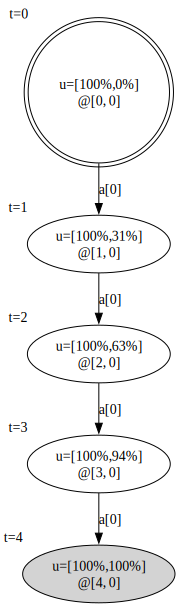

In [27]:
search = Search(2, n_p=[1, 10], a=[(0, [1])], u0=[1, 0], L_term=[0, 1])
search.search()

search.draw()

### $ l = 3 \land L_{term} = \{0,1\} $
* $ L = \{0,1,2\} $
* $ a $
  * a[0]: $ t_{0 \rightarrow \{1\}}$
  * a[1]: $ t_{0 \rightarrow \{1,2\}}$

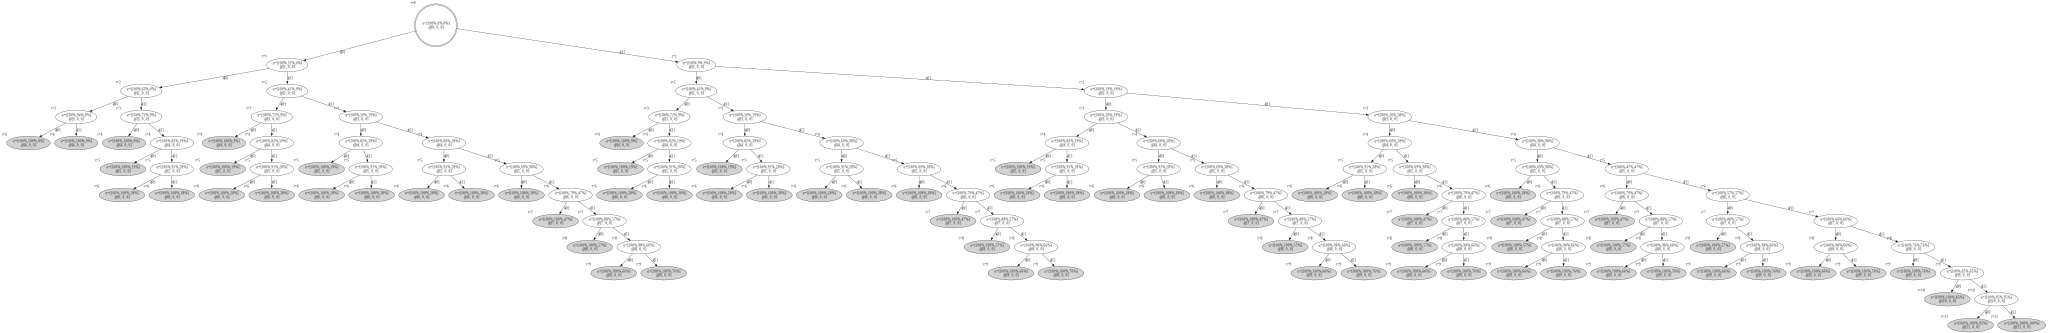

In [28]:
search = Search(3, n_p=[1, 10, 100], a=[(0, [1]), (0, [1, 2])], u0=[1, 0, 0], L_term=[0, 1])
search.search()

search.draw()

# import pygraphviz as pgv
#
# num_p_1 = 10
# num_p_2 = 10
# num_p_3 = 10 * 10
#
# G = pgv.AGraph(directed=True)
# G.add_node("1", label="(1,0) @(0,0)", color="cyan", root=True)
# G.add_node("2", label="(1,.3) @(1,0)")
# G.add_node("3", label="(1,.6) @(2,0)")
# G.add_node("4", label="(1,.9) @(3,0)")
# G.add_node("5", label="(1,1) @(4,0)", color="red")
# G.add_node("6", label="(1,.0) @(1,0)")
# G.add_node("7", label="(1,.4) @(2,0)")
# G.add_node("8", label="(1,.1) @(2,0)")
# G.add_edge("1", "2", label="A")
# G.add_edge("2", "3", label="A")
# G.add_edge("3", "4", label="A")
# G.add_edge("4", "5", label="A")
# G.add_edge("1", "6", label="B")
# G.add_edge("6", "7", label="A")
# G.add_edge("6", "8", label="B")
# # TODO
#
# G.layout("dot")
# G